# Titanic Survival Prediction

## Importing Libraries and Datasets

In [24]:
# Import Packages for Feature Engineering and Data Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Import Packages for Machine Learning Modelling
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


In [25]:
train = pd.read_csv(r"D:\AI\Predicting-Titanic-Survivors/Datasets/train.csv")
test = pd.read_csv(r"D:\AI\Predicting-Titanic-Survivors/Datasets/test.csv")


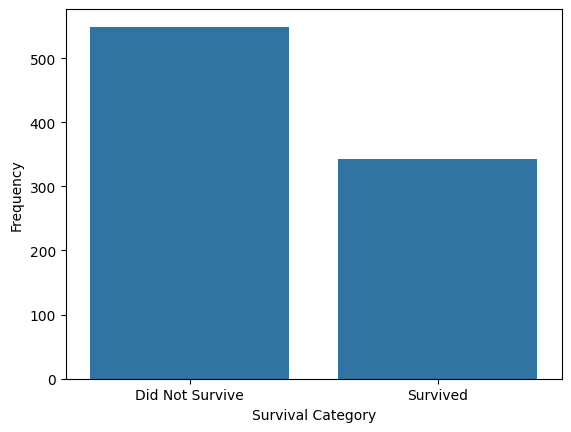

In [26]:
# Plot Target Distribution In Train Dataset
sns.countplot(data=train, x='Survived')
plt.ylabel('Frequency')
plt.xlabel('Survival Category')
plt.xticks([0.0, 1.0], ['Did Not Survive', 'Survived']);

## Feature Engineering and Data Cleaning

In [27]:
# Create Wrangler Function to Preprocess and Clean Dataset
def wrangler (df):
    df = df.copy()
    # Replace Column Elements for Readability
    emb = {"Q" : "Queenstown" , "S" : "Southampton" , "C" : "Cherbourg" }
    df['Embarked'].replace(emb)
    
    cla = {1:"First Class", 2: "Second Class", 3 :"Third Class"}
    df['Pclass'].replace(cla).astype('object')

    # Transform Ticket into Lettered Column by Ticket Type (Numeric or Alphanumeric Ticket)
    def has_letters(string):
        return any(char.isalpha() for char in string)
    df['Ticket_Type'] = df['Ticket'].apply(has_letters).astype('object')
    
    # Separate Dataset Features into Categorical and Numeric Variable (Useful For Visualizations)
    num_cols = list(df.select_dtypes(exclude=['object']).columns)
    cat_cols = list(df.select_dtypes(include=['object']).columns)
    
    # Encode the Categorical Features
    le = LabelEncoder()
    for col in cat_cols:
        le.fit(df[col])
        df[col] = le.transform(df[col])
      
    # Dropped Unneeded Columns After Feature Engineering
    drop_cols = []
    drop_col_list = ["Name", "Cabin", "Ticket"]
    for col in df.columns:
        if col in drop_col_list:
            drop_cols.append(col)
    
    df = df.drop(columns = drop_cols)
    return df

In [28]:
# Preprocess Test and Train Datasets
train = wrangler(train)
test = wrangler(test)

# Create Target, Features, and Train-Test Split
X_train = train.drop(['Survived', 'PassengerId' ], axis=1)
y_train = train['Survived']
X_test = test.drop(['PassengerId' ], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Prediction Using the Logistic Regression Model

In [29]:
# Create Pipeline With Scaler, Imputer and Model  
model = LogisticRegression(random_state= 42, max_iter=1000)
scaler = RobustScaler()
imputer = KNNImputer(n_neighbors=5)
pipeline = Pipeline(steps=[('i', imputer), ('s', scaler) , ('m', model)])

# Fit the Pipeline on Training Data
pipeline.fit(X_train, y_train)

# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = pipeline.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/Lenovo/Downloads/LRPredictions.csv', index=False)
accuracy = pipeline.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

 Training Accuracy: 0.800561797752809


In [30]:
# Evaluate on training set
train_accuracy = pipeline.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on validation set
val_accuracy = pipeline.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")

# Make predictions on validation set
val_predictions = pipeline.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, val_predictions))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, val_predictions))


Training Accuracy: 0.800561797752809
Validation Accuracy: 0.8044692737430168
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

Confusion Matrix:
[[89 16]
 [19 55]]


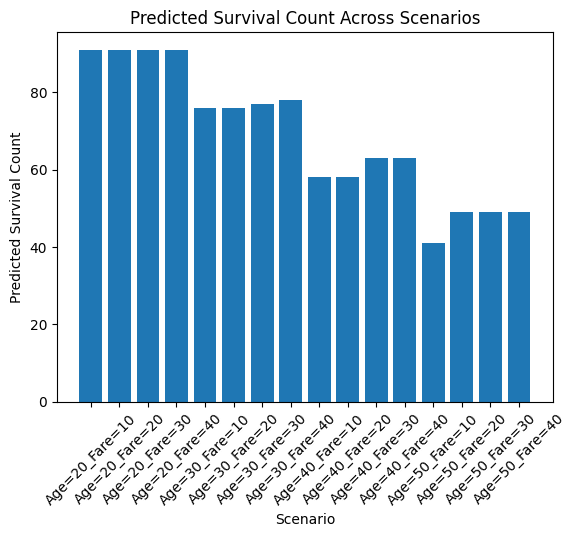

In [31]:
# Select input variables for sensitivity analysis
input_variables = ['Age', 'Fare']

# Define scenarios for each input variable
age_scenarios = [20, 30, 40, 50]
fare_scenarios = [10, 20, 30, 40]

# Make predictions for each scenario
scenario_predictions = {}
for age_value in age_scenarios:
    for fare_value in fare_scenarios:
        # Set input variables' values for the scenario
        scenario_input = X_val.copy()
        scenario_input['Age'] = age_value
        scenario_input['Fare'] = fare_value
        
        # Make predictions for the scenario
        predictions = pipeline.predict(scenario_input)
        
        # Store scenario predictions
        scenario_name = f"Age={age_value}_Fare={fare_value}"
        scenario_predictions[scenario_name] = predictions

# Analyze results
# Example: Calculate and visualize the distribution of predictions across scenarios
prediction_counts = {scenario_name: np.sum(predictions) for scenario_name, predictions in scenario_predictions.items()}
plt.bar(prediction_counts.keys(), prediction_counts.values())
plt.xlabel('Scenario')
plt.ylabel('Predicted Survival Count')
plt.title('Predicted Survival Count Across Scenarios')
plt.xticks(rotation=45)
plt.show()

In [32]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = pipeline.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/Lenovo/Downloads/LRPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open(r'D:\AI\Predicting-Titanic-Survivors/Models/LRModel.pkl', 'wb'))

## Prediction Using the Logistic Regression Cross Validation Model

In [33]:
# Create Pipeline With Scaler, Imputer and Model
model = LogisticRegressionCV(cv=5, max_iter = 1000, random_state=42, n_jobs=-1)
scaler = RobustScaler()
imputer = KNNImputer(n_neighbors=5)
pipeline = Pipeline(steps=[('i', imputer), ('s', scaler) , ('m', model)])

# Fit the Pipeline on Training Data
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

 Training Accuracy: 0.8033707865168539


In [34]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = pipeline.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/Lenovo/Downloads/LRPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open(r'D:\AI\Predicting-Titanic-Survivors/Models/LRModel.pkl', 'wb'))

## Prediction Using the Decision Tree Classifier

In [35]:
# Create Pipeline With Scaler, Imputer and Model
pipeline = Pipeline([('scaler', StandardScaler()),  ('imputer', KNNImputer(n_neighbors=5)), ('classifier', DecisionTreeClassifier(random_state=42))])

# Prepare Hyperparameter Tuning Dictionary
param_grid = {'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [None, 5, 10, 15],
              'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4]}

# Tune Hyperparameters 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Select the Best Estimator to Fit Training Data
best_estimator = grid_search.best_estimator_
accuracy = best_estimator.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
 Training Accuracy: 0.8890449438202247


In [36]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = best_estimator.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/Lenovo/Downloads/LRPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open(r'D:\AI\Predicting-Titanic-Survivors/Models/LRModel.pkl', 'wb'))

In [38]:
from sklearn.svm import SVC

# Create Pipeline With Scaler, Imputer, and SVM Model
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer(n_neighbors=5)), ('classifier', SVC(random_state=42))])

# Prepare Hyperparameter Tuning Dictionary
param_grid_svm = {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf', 'poly']}

# Tune Hyperparameters
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)
best_params_svm = grid_search_svm.best_params_
print("Best Parameters (SVM):", best_params_svm)

# Select the Best Estimator to Fit Training Data
best_estimator_svm = grid_search_svm.best_estimator_
accuracy_svm = best_estimator_svm.score(X_train, y_train)
print(f"Training Accuracy (SVM): {accuracy_svm}")

# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions_svm = best_estimator_svm.predict(X_test)
model_output_svm = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_svm})
model_output_svm.to_csv('C:/Users/Lenovo/Downloads/SVMPredictions.csv', index=False)


Best Parameters (SVM): {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Training Accuracy (SVM): 0.8651685393258427


## Prediction Using Random Forest Classifier

In [39]:
# Create Pipeline With Scaler, Imputer and Model
pipeline = Pipeline([('scaler', StandardScaler()),  ('imputer', KNNImputer(n_neighbors=5)), ('classifier', RandomForestClassifier(random_state=42))])

# Prepare Hyperparameter Tuning Dictionary
param_grid = {'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [None, 5, 10, 15],
              'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4], 'classifier__bootstrap': [True, False]}
# Tune Hyperparameters 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
#grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Select the Best Estimator to Fit Training Data
best_estimator = grid_search.best_estimator_
accuracy = best_estimator.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

Fitting 15 folds for each of 216 candidates, totalling 3240 fits
Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
 Training Accuracy: 0.8595505617977528


In [ ]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = best_estimator.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/Lenovo/Downloads/LRPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open(r'D:\AI\Predicting-Titanic-Survivors/Models/LRModel.pkl', 'wb'))

## Check Feature Importance of Best Model and Save Best Model for Web App

In [ ]:
# Saving the Best Model to appmodel.pkl for Web App
pipeline = Pipeline([('scaler', StandardScaler()),  ('imputer', KNNImputer(n_neighbors=5)), ('classifier', DecisionTreeClassifier(random_state=42, criterion = 'entropy', max_depth = 5, min_samples_leaf = 2, min_samples_split = 2))])
pipeline.fit(X_train, y_train)
pickle.dump(pipeline, open(r'D:\AI\Predicting-Titanic-Survivors/Models/LRModel.pkl', 'wb'))

# Extracting Feature Importance in the Best Model
decision_tree = pipeline.named_steps['classifier']
importances = decision_tree.feature_importances_
feature_names = X_train.columns
feature_importances = dict(zip(feature_names, importances))

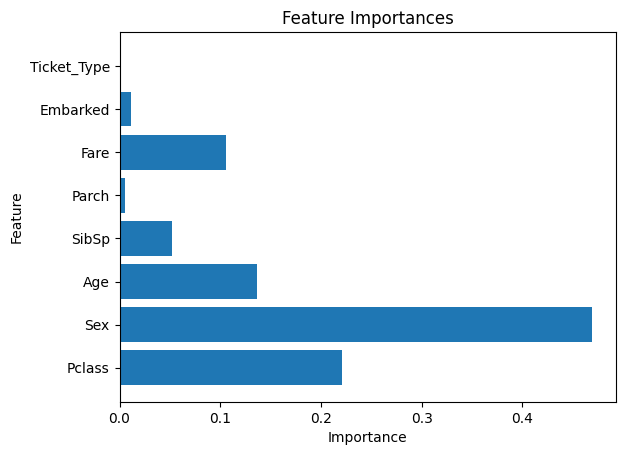

In [ ]:
# Visualization of the Most Important Determinants of Survival
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

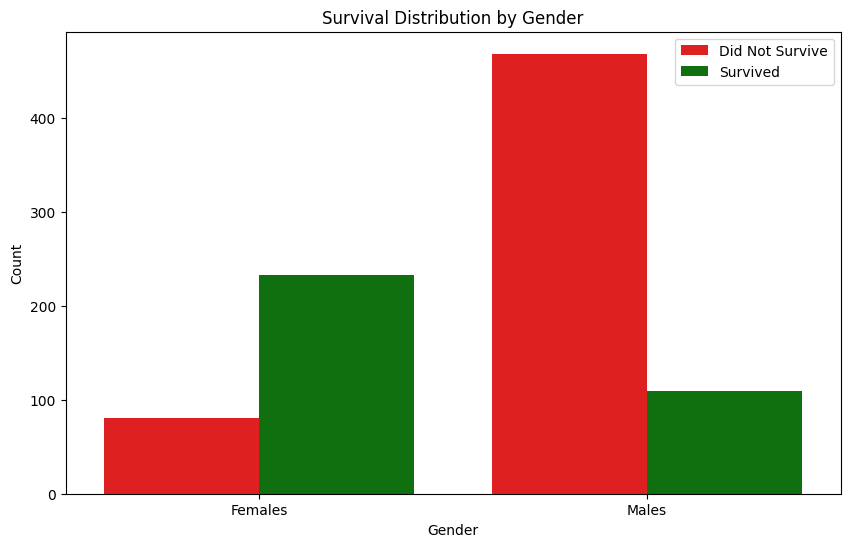

        Did Not Survive  Survived
Female               81       233
Male                468       109


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='Sex', hue='Survived', palette={0: 'red', 1: 'green'})
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Survival Distribution by Gender')
plt.legend(['Did Not Survive', 'Survived'])
plt.xticks([0.0, 1.0], ['Females', 'Males']);
plt.show()

# Counting Survivors and Non-survivors by Gender
survival_by_gender = train.groupby(['Sex', 'Survived']).size().unstack()
survival_by_gender.columns = ['Did Not Survive', 'Survived']
survival_by_gender.index = ['Female', 'Male']
print(survival_by_gender)

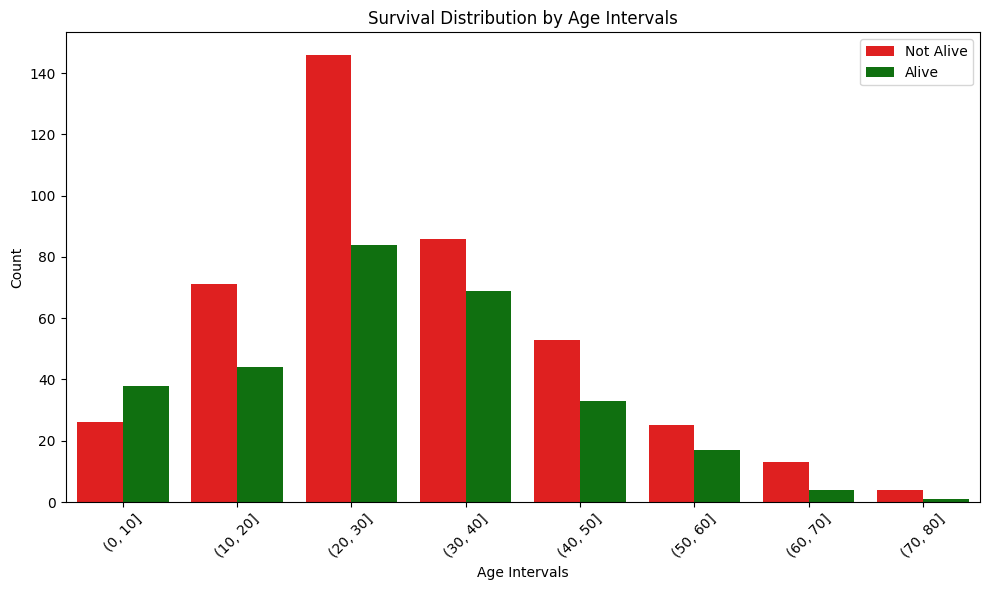

In [ ]:
# Define age intervals
age_intervals = pd.cut(train['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])

# Define a new column indicating whether each passenger is alive or not
train['Survival_Status'] = train['Survived'].map({0: 'Not Alive', 1: 'Alive'})

# Plotting Survival Distribution by Age Intervals
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x=age_intervals, hue='Survival_Status', palette={'Not Alive': 'red', 'Alive': 'green'})
plt.xlabel('Age Intervals')
plt.ylabel('Count')
plt.title('Survival Distribution by Age Intervals')
plt.legend(['Not Alive', 'Alive'])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4500\3235240121.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=train, x='Pclass', y='Survived', ci=None, palette='viridis')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4500\3235240121.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train, x='Pclass', y='Survived', ci=None, palette='viridis')


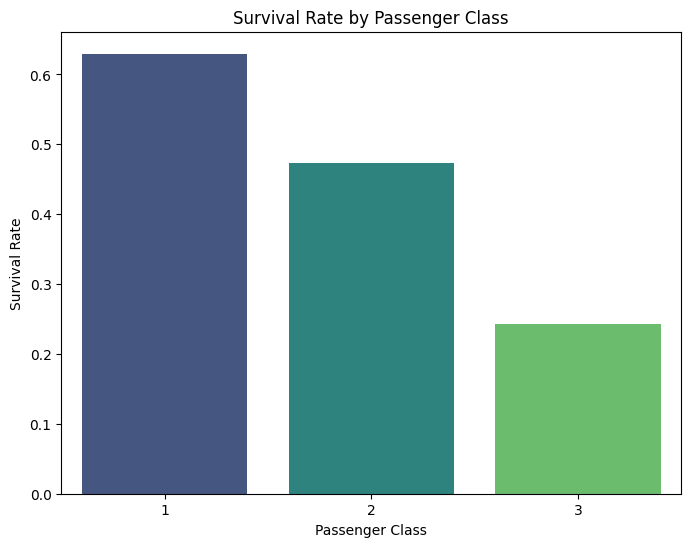

In [ ]:

# Visualizing Survival Rate by Passenger Class without Confidence Interval
plt.figure(figsize=(8, 6))
sns.barplot(data=train, x='Pclass', y='Survived', ci=None, palette='viridis')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class')
plt.show()



In [ ]:
# Define age intervals
age_intervals = pd.cut(train['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])

# Calculate survival rate for each age group
age_group_survival = train.groupby(age_intervals,observed=False)['Survived'].mean().reset_index()

# Rename columns for clarity
age_group_survival.columns = ['Age Group', 'Survival Rate']

# Display the DataFrame
print(age_group_survival)

# Calculate survival rate for each passenger class
class_survival_rate = train.groupby('Pclass')['Survived'].mean().reset_index()

# Rename columns for clarity
class_survival_rate.columns = ['Passenger Class', 'Survival Rate']

# Display the DataFrame
print(class_survival_rate)


  Age Group  Survival Rate
0   (0, 10]       0.593750
1  (10, 20]       0.382609
2  (20, 30]       0.365217
3  (30, 40]       0.445161
4  (40, 50]       0.383721
5  (50, 60]       0.404762
6  (60, 70]       0.235294
7  (70, 80]       0.200000
   Passenger Class  Survival Rate
0                1       0.629630
1                2       0.472826
2                3       0.242363
